In [1]:
import simpy
import concurrent
import myutils

In [2]:
G = myutils.load_map()

In [3]:
class StationModel():
    stations = set()
    def __init__(self, routeId, varId) -> None:
        src = myutils.STOPS_FILE_NAME + str(varId)
        api = myutils.STOPS_API(id=routeId, varId=varId)
        stops_df = myutils.load_data(route=routeId, source=src, api=api)
        self.stops_df = stops_df[["StopId", "Lat", "Lng"]]
        self.stops_df = self.stops_df.rename(columns={"StopId":"stop_id", "Lat":"lat", "Lng":"lng"})

        StationModel.stations.update(self.stops_df["stop_id"].tolist())

In [8]:
class BusModel():
    def __init__(self, id) -> None:
        self.route = id
        timetables_df = myutils.load_data(route=id, source=myutils.TIMETABLE_FILE_NAME, api=myutils.TIMETABLE_API(id))
        
        self.vars = list()
        self.stations = dict()
        self.paths_df = dict()
        self.trips_df = dict()
        for i, row in timetables_df.iterrows():
            varId = row["RouteVarId"]
            self.vars.append(varId)
    
            self.stations[varId] = StationModel(routeId=id, varId=varId)

            src = myutils.PATHS_FILE_NAME + str(varId)
            self.paths_df[varId] = myutils.load_data(route=id, source=src, api=myutils.PATHS_API(id=id, varId=varId))
        
            tripId = row["TimeTableId"]
            src = myutils.TRIPS_FILE_NAME + str(varId)
            self.trips_df[varId] = myutils.load_data(route=id, source=src, api=myutils.TRIPS_API(id=id, tripId=tripId))

    def prepare_path(self):
        is_used_local = False

        for varId in self.paths_df.keys():
            source = myutils.DF_FILE_NAME + str(varId)
            try:
                eval_columns = ["edge", "route"]
                self.paths_df[varId] = myutils.load_path_data(route=self.route, source=source, eval_columns=eval_columns)
                is_used_local = True
            except FileNotFoundError:
                break

        if is_used_local: return

        with concurrent.futures.ProcessPoolExecutor() as executor:
            params = [(varId, self.paths_df[varId], self.stations[varId].stops_df, G) for varId in self.paths_df.keys()]
            results = executor.map(myutils.get_routes_from_paths, params)
            for result in results:
                id, df = result
                self.paths_df[id] = df
                myutils.save_path_data(route=self.route, var=id, df=df)

    def prepare_graph(self):
        self.station_num = {var: self.paths_df[var][self.paths_df[var]["station"]].shape[0] for var in self.paths_df.keys()}
        self.station_max = self.station_num[max(self.station_num, key=lambda id: self.station_num[id])]
        
        self.path_count = {var: self.paths_df[var].shape[0] for var in self.paths_df.keys()}
        self.path_max = self.path_count[max(self.path_count, key=lambda id: self.path_count[id])]
        
        self.x = {var: self.paths_df[var].apply(lambda path: G.nodes[path["edge"][0]]["x"], axis="columns") for var in self.paths_df.keys()}
        self.max_x = self.x[max(self.x, key=lambda id: self.x[id].max())].max()
        self.min_x = self.x[min(self.x, key=lambda id: self.x[id].min())].min()

        self.y = {var: self.paths_df[var].apply(lambda path: G.nodes[path["edge"][0]]["y"], axis="columns") for var in self.paths_df.keys()}
        self.max_y = self.y[max(self.y, key=lambda id: self.y[id].max())].max()
        self.min_y = self.y[min(self.y, key=lambda id: self.y[id].min())].min()

        self.travel_time = {var: self.paths_df[var]["travel_times"].sum() for var in self.paths_df.keys()}


In [9]:
buses = list()
bus_ids = [8, 51, 30]
for id in bus_ids:
    bus = BusModel(id)
    buses.append(bus)
    bus.prepare_path()

In [10]:
north = 0
south = 0
east = 0
west = 0
padding = 0.04

for i, bus in enumerate(buses):
    bus.prepare_graph()
    if i == 0:
        east = bus.max_x
        west = bus.min_x
        north = bus.max_y
        south = bus.min_y
    else:
        east = max(east, bus.max_x)
        west = min(west, bus.min_x)
        north = max(north, bus.max_y)
        south = min(south, bus.min_y)

padding_ns = (north - south) * padding
padding_ew = (east - west) * padding
bbox = north + padding_ns, south - padding_ns, east + padding_ew, west - padding_ew

In [11]:
trunc_G = myutils.ox.truncate.truncate_graph_bbox(G, *bbox)

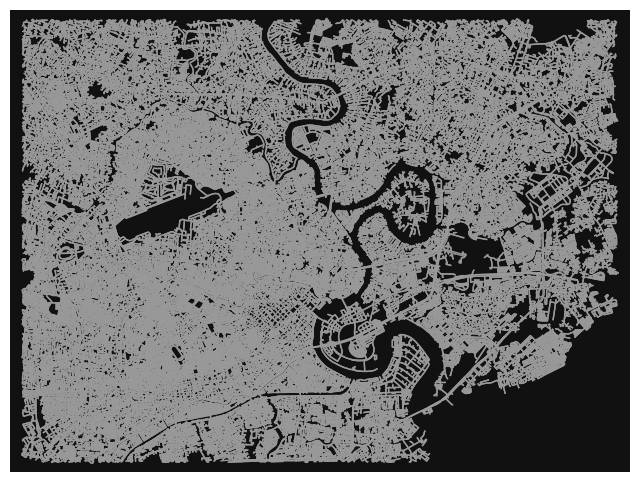

In [12]:
fig, ax = myutils.ox.plot_graph(trunc_G, node_size=0, edge_linewidth=1, show=False)

In [14]:
for bus in buses:
    r = lambda: myutils.rd.randint(0,255)
    color = f"#{r():02x}{r():02x}{r():02x}"
    for var in bus.vars:
        ax.scatter(bus.x[var], bus.y[var], s=10, c=color, alpha=1, edgecolor="none")

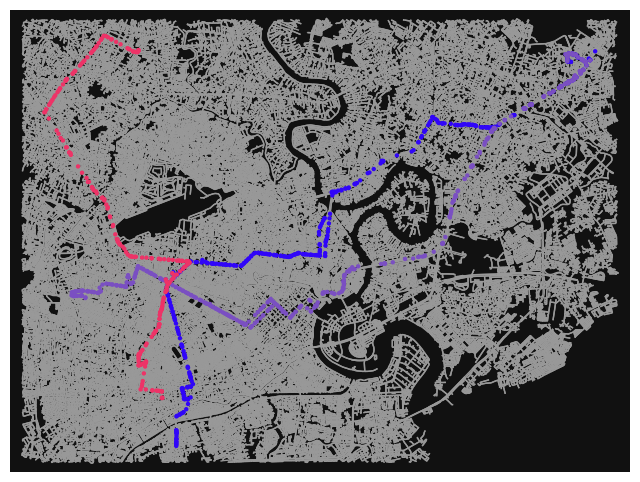

In [15]:
ax.figure